------------------------ Let's get the party started! -------------------------------------
../data/macro_economy//china_macro_economy_daily.csv
../data/macro_economy//OECD-world-economy-daily.csv
../data/components//components-top10.csv
../data/000300.SH/000300.SH.csv ===============
Factors Shape: (2671, 135)
---- Trend Distribution Check --------
0.0     960
1.0     558
2.0    1153
dtype: int64
input data shape:  (2671, 135)
input label shape:  (2671,)
training size:  2380
testing size:  280
Train on 2380 samples, validate on 280 samples
Epoch 1/60
2380/2380 [==============================] - 6s - loss: 0.0590 - val_loss: 0.0449
Epoch 2/60
2380/2380 [==============================] - 4s - loss: 0.0223 - val_loss: 0.0388
Epoch 3/60
2380/2380 [==============================] - 4s - loss: 0.0180 - val_loss: 0.0349
Epoch 4/60
2380/2380 [==============================] - 4s - loss: 0.0163 - val_loss: 0.0382
Epoch 5/60
2380/2380 [==============================] - 4s - loss: 0.0144 - val_l

2360/2360 [==============================] - 27s - loss: 0.6874 - acc: 0.6932 - val_loss: 0.8037 - val_acc: 0.6964
Epoch 79/100
2360/2360 [==============================] - 27s - loss: 0.6892 - acc: 0.6975 - val_loss: 0.7579 - val_acc: 0.6893
Epoch 80/100
2360/2360 [==============================] - 27s - loss: 0.6936 - acc: 0.7025 - val_loss: 0.7574 - val_acc: 0.6607
Epoch 81/100
2360/2360 [==============================] - 27s - loss: 0.7209 - acc: 0.6856 - val_loss: 0.7110 - val_acc: 0.6929
Epoch 82/100
2360/2360 [==============================] - 28s - loss: 0.6937 - acc: 0.6970 - val_loss: 0.7546 - val_acc: 0.7000
Epoch 83/100
2360/2360 [==============================] - 28s - loss: 0.6833 - acc: 0.7017 - val_loss: 0.8613 - val_acc: 0.6179
Epoch 84/100
2360/2360 [==============================] - 27s - loss: 0.6841 - acc: 0.7106 - val_loss: 0.7701 - val_acc: 0.6786
Epoch 85/100
2360/2360 [==============================] - 27s - loss: 0.6870 - acc: 0.6996 - val_loss: 0.7721 - val_a

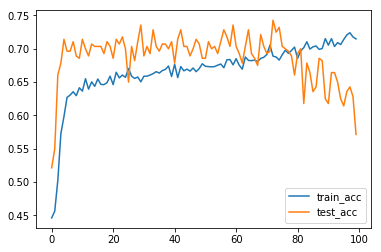

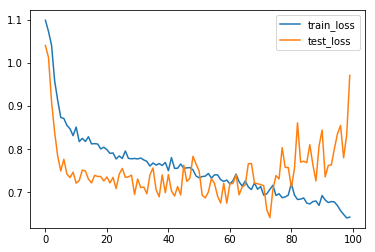

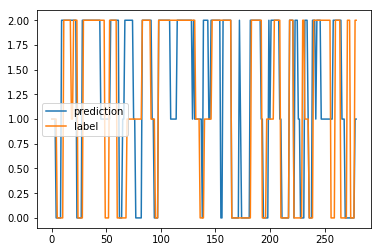

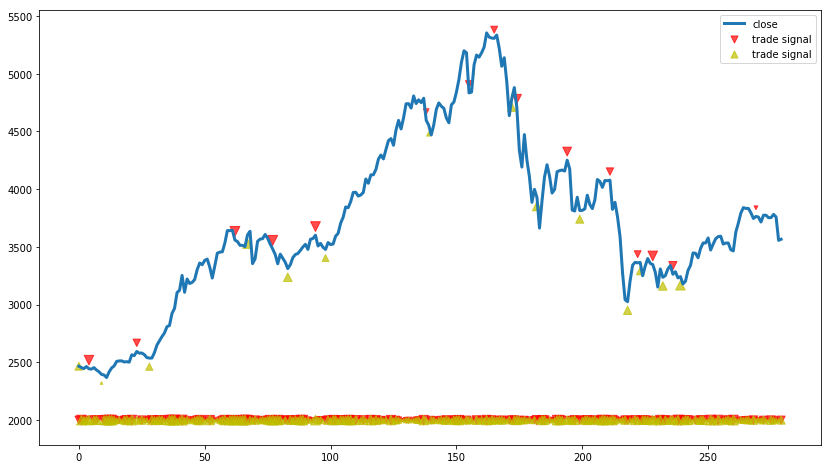

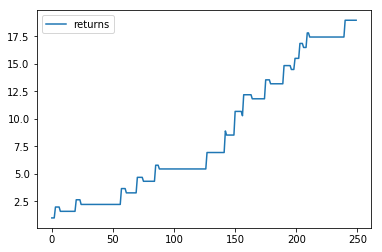

Trading ratio:  0.10714285714285714
max_drawdown:  0.0
mean 0.137068
std 0.132104
max 0.476009
min 0.00784331
 buy & hold:  0.445769603412
sharpe_ratio 1.03758
return sum:  6539.83 return ratio:  2.65114987494 Alpha:  2.20538027153


In [9]:
'''
QUTUR Model
Quantatative Timing based on Unsupervised Learning and RNN 
@Author Z.Zhao
12/18/2017

1. fetching all factors from various datasource
2. preprocessing data (alignment, padding, concatatenation, normazlizing)
3. reducing dimensionality via LSTM-based AutoEncoder
4. feeding compressed sequence data to LSTM (multivariate sequence classifier)
5. retrieving Timing signal i.e. Trend label, then execute trading accordingly
6. calculating Return of Rate.
'''

from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
'''
Preparing data
'''
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import math

'''
Reading Macro economy factors from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def strip_comma(x):
    return float(str(x).replace(',',''))
def read_macro_economy(base_dir = '../data/macro_economy/', 
                       filename = 'china_macro_economy_daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(31)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) #中文读取出问题，所以skip row1
    df = pd.read_csv(filename, index_col=0, sep=',', 
                     skiprows=1, usecols=usecols,
                     names = names, parse_dates=True,
                     converters = {11: strip_comma, 22: strip_comma}
                    )
    return df[start_date : end_date]


'''
Reading World economy factors sponsored by OECD from CSV
Notice: data are distributed monthly, need to be filled for daily usage
'''
def read_world_economy(base_dir = '../data/macro_economy/', 
                       filename = 'OECD-world-economy-daily.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(46)],
                       usecols = None):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1, usecols=usecols,parse_dates=True,
                     names = names
                    )
    return df[start_date : end_date]

'''
Reading Top10 Components CSV
Data has been assigned weight according to their ratio in the market

# Ref: data calculated from data/generate/FetchingComponentsData.ipynb
'''
def read_components(base_dir = '../data/components/', 
                       filename = 'components-top10.csv',
                       start_date = '2002-01-04', end_date = '2017-11-30',
                       names = [i for i in range(10)]):
    filename = base_dir +'/'+ filename
    print (filename) 
    df = pd.read_csv(filename, index_col=0, 
                     skiprows=1,parse_dates=True,
                     names = names
                    )
    df = df.fillna(0)
    return df[start_date : end_date]

'''
Reading ohlcv transaction data for a stock

'''
def readWSDFile(baseDir, stockCode, startDate='2005-01-04', endDate= '2015-12-31', usecols=None, 
                names=['date','pre_close','open','high','low','close','change','chg_range',
                                               'volume','amount','turn']):
    # 解析日期
    filename = baseDir+stockCode+'/'+stockCode+'.csv'
    print (filename, "===============")
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()
    df = pd.read_csv(filename, index_col=0, sep=',', header=None,usecols=usecols,
                            skiprows=1, names=names,
                           parse_dates=True, date_parser=dateparse)
    df = df.fillna(0)
    return df[startDate : endDate]

'''
Reading Technical indicators of a stock
'''
def readWSDIndexFile(baseDir, stockCode, startYear, yearNum=1):
    # parse date
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d').date()

    df = 0
    for i in range(yearNum):
        tempDF = pd.read_csv(baseDir+'I'+stockCode+'/wsd_'+stockCode+'_'+str(startYear+i)+'.csv', index_col=0, sep=',', parse_dates=True, date_parser=dateparse
                             # , usecols=usecols
                             )
        if i==0: df = tempDF
        else: df = df.append(tempDF)
    df = df.fillna(0)
    return df

'''
Preparing all the useful data
'''
# 整理好多因子输入，以dataframe返回数据+标签
def data_prepare(retrace = 0.618, dtype = 'all', start_date='2005-01-04', end_date= '2015-12-31'):
    # prepare data
    baseDir = '../data/'
    stockCodes = ['000300.SH']
    i = 0
    startYear = 2005
    number =11
    print("------------------------ Let's get the party started! -------------------------------------")
    ## Load data from CSV
    dfm = read_macro_economy(start_date = start_date, end_date = end_date)
    dfw = read_world_economy(start_date = start_date, end_date = end_date)
    dfc = read_components(start_date = start_date, end_date = end_date)
    df = readWSDFile(baseDir, stockCodes[i], start_date, end_date)
    dfi = readWSDIndexFile(baseDir, stockCodes[i], startYear, number)
    allDF = df
    if dtype == 'all':
        allDF = pd.concat([df, dfi, dfm, dfw, dfc], axis=1)
    elif dtype == 'only_m':
        allDF = pd.concat([df, dfm], axis=1) # macro economy 
    elif dtype == 'only_i':
        allDF = pd.concat([df, dfi], axis=1) # technical indicators
    elif dtype == 'only_w':
        allDF = pd.concat([df, dfw], axis=1) # world economy
    elif dtype == 'only_c':
        allDF = pd.concat([df, dfc], axis=1) # constitutant stock
    elif dtype == 'im':
        allDF = pd.concat([df, dfi, dfm], axis=1) 
    elif dtype == 'ic':
        allDF = pd.concat([df, dfi, dfc], axis=1) 
    else:
        pass
    allDF = allDF.fillna(0)
    sample_num = np.shape(df)[0]
    labelDF = pd.Series(np.zeros(sample_num))
    print ("Factors Shape:", np.shape(allDF))
    
    # 求出 trend
    price = df['close']
    start = 0
    while price[start] > price[start+1]:
        labelDF[start] = 1 #flat
        start +=1
    
    #find peak, find trough, calculate retracement and label trend accordingly
    i = start
    while i < sample_num - 1:
        cursor = i
        while cursor < sample_num - 1 and price[cursor] <= price[cursor+1]:
            cursor += 1
        peak = cursor
        while cursor < sample_num - 1 and price[cursor] >= price[cursor+1]:
            cursor += 1
        trough = cursor
        retracement = (price[peak] - price[trough]) / (price[peak] - price[i])
        mark = 1 # flat
        if retracement < retrace:
            mark = 2 # UP
        elif retracement > 1 + retrace:
            mark = 0 # DOWN
        for k in range(i, cursor+1):
            labelDF[k] = mark
        i = cursor

    print("---- Trend Distribution Check --------")
    print(labelDF.value_counts().sort_index())
    
    # make a deep copy of Price Difference before normalizing
    priceDF = allDF['change'].copy(deep=True)
    # normalize(x)
    scaler = preprocessing.MinMaxScaler()
    input_data = scaler.fit_transform(allDF)
    print ("input data shape: ", np.shape(input_data)) #  days *  factors
    print ("input label shape: ", np.shape(labelDF))
    labels = labelDF.values
    #input_data = np.concatenate((input_data, labels.reshape(-1,1)), axis = 1) # historical data as part of the series
    return input_data, labels, priceDF, price # train/test data, labels, prices difference, actual price for yield calucluation


###### Hyper paramters #########
time_steps = 8
n_neurons = 200
num_classes = 3
batch_size = 20 # specify batch size explicitly; no shuffle but successive sequence
n_epoch_ae = 60
n_epoch = 100
train_ratio = 0.9
dropout = 0.3
concate = False # without using historical labels as input data
t0 = time()
dataset,labels, priceDF, price = data_prepare()
segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
train_size = int(segment_num * train_ratio)
test_size = segment_num - train_size
data_dim = np.shape(dataset)[1] #input + historic labels

#divide training/validation dataset; numpy array
train_x = dataset[0 : train_size * batch_size + time_steps]
test_x = dataset[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]

#historic label as input time series
train_historic_label = np.array(labels[0 : train_size * batch_size + time_steps]).reshape(-1,1)
test_historic_label = np.array(labels[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]).reshape(-1,1)

#Sliding window: label is just 1 step further after sequence data
train_y = labels[time_steps : train_size * batch_size + time_steps]
test_y = labels[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]

# add historical trends or not
if concate:
    data_dim += 1
    train_x = np.concatenate((train_x, train_historic_label), axis = 1)
    test_x = np.concatenate((test_x, test_historic_label), axis = 1)

train_sample = len(train_x) - time_steps
b = np.array([[]])
# creating data in a rolling window view 
for i in range(train_sample):
    b = np.append(b, train_x[i : time_steps + i])
train_x = b.reshape(train_sample, time_steps, data_dim)
print("training size: ", train_sample)

test_sample = len(test_x) - time_steps
b = np.array([[]])
for i in range(test_sample):
    b = np.append(b, test_x[i : time_steps + i])
test_x = b.reshape(test_sample, time_steps, data_dim)
print("testing size: ", test_sample)

train_y = np.array(train_y, dtype=np.int32)
test_y = np.array(test_y, dtype=np.int32)

############## AutoEncoder MODEL ##########################
latent_dim = 16
layer1 = 128
layer2 = 32
layers = [layer2,layer1]
inputs = Input(shape=(time_steps, data_dim))
encoded = LSTM(units = layer1, return_sequences = True)(inputs)
encoded = LSTM(units = layer2, return_sequences = True)(encoded)
encoded = LSTM(units = latent_dim, return_sequences = False)(encoded) # most hidden layer, only preseve the last step's output

repeated_out = RepeatVector(time_steps)(encoded)  # repeat intermediate output [2D -> 3D]

decoded = LSTM(layer2, return_sequences=True)(repeated_out)
decoded = LSTM(layer1, return_sequences=True)(decoded)
decoded = LSTM(data_dim, return_sequences=True)(decoded)  # output layer as a comparison

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)  ## encoder for dimensionality reduction

sequence_autoencoder.compile(optimizer='rmsprop', 
                             loss='mean_squared_error',
                             )
history = sequence_autoencoder.fit(x = train_x, y = train_x, 
                         batch_size=batch_size,
                         epochs=n_epoch_ae,
                         shuffle=False,
                         validation_data = (test_x, test_x))
print ("Params: ", "time_steps:", time_steps, " latent_dim:", 
       latent_dim, " batch_size: ",batch_size, " n_epoch: ", 
       n_epoch, 'layers', layers, "\n Time cost: ", (time() - t0))

#encoder.save('autoencoder-135d-8ts-100ep-128-32-8.h5')
# compressed_data = encoder.predict(dataset)

'''
## load model from file
encoder = load_model('autoencoder-135d-8ts-100ep-128-32-8.h5')
'''
# rolling window
b = np.array([[]])
n_sample = len(dataset) - time_steps
for i in range(n_sample):
    b = np.append(b, dataset[i : time_steps + i])
dataset = b.reshape(n_sample, time_steps, data_dim)

compressed_data = encoder.predict(dataset)
dataset = compressed_data

################################################################
########### Prediction Model ###################################
# divide training/validation dataset 
segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
train_size = int(segment_num * train_ratio)
test_size = segment_num - train_size
data_dim = np.shape(dataset)[1]
print ("prediction model input data shape: ", np.shape(dataset)) 

#divide training/validation dataset; numpy array
train_x = dataset[0 : train_size * batch_size + time_steps]
test_x = dataset[train_size * batch_size : (train_size + test_size) * batch_size + time_steps]
# rolling window
train_sample = len(train_x) - time_steps
print ("train sample: ", train_sample, "data_dim",data_dim)
b = np.array([[]])
for i in range(train_sample):
    b = np.append(b, train_x[i : time_steps + i])
train_x = b.reshape(train_sample, time_steps, data_dim)
print("training size: ", train_sample)

test_sample = len(test_x) - time_steps
b = np.array([[]])
for i in range(test_sample):
    b = np.append(b, test_x[i : time_steps + i])
test_x = b.reshape(test_sample, time_steps, data_dim)
print("testing size: ", test_sample)

#Sliding window: label is just 1 step further after sequence data
train_y = labels[time_steps : train_size * batch_size + time_steps]
test_y = labels[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]
train_y = np.array(train_y, dtype=np.int32)
test_y = np.array(test_y, dtype=np.int32)

layers = 5
early_stop = EarlyStopping(monitor='val_loss',patience = 40, mode='min') #when it stops deacreasing, stop
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=True,stateful=True,dropout = dropout,
               batch_input_shape=(batch_size, time_steps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(n_neurons, return_sequences=True,dropout = dropout, stateful=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(n_neurons, return_sequences=True,dropout = dropout, stateful=True)) 
model.add(LSTM(n_neurons, dropout = dropout,stateful=True))  # return a single vector of dimension 32
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', #for integer class, not one hot encoding
              optimizer='rmsprop',
              metrics=['accuracy'])   

history = model.fit(train_x, train_y,
          batch_size=batch_size, 
          epochs=n_epoch,
          shuffle=False,
          validation_data=(test_x, test_y),
          callbacks = [early_stop]         
                   )

print ("Params: ", "time_steps:", time_steps, "  n_neurons:", n_neurons, 
       " batch_size: ",batch_size, " n_epoch: ", n_epoch, 'layers'," data_dim ",data_dim,
       layers, "\n Time cost: ", (time() - t0))
print("Add Dropout between every layer: ",dropout)
print('Avg. Train ACC = ', np.average(history.history['acc']))
print('Avg. Test ACC = ', np.average(history.history['val_acc']))

# plot history
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='test_acc')
plt.legend()
plt.show()
# loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()
# prediction check & visualization
#model.save('classifier.h5')
predictions = np.argmax(model.predict(test_x, batch_size=batch_size), axis = 1)
plt.plot(predictions, label = 'prediction')
plt.plot(test_y, label = 'label')
plt.legend()
plt.show()
'''
T + 1 trading rules.
Trading stratigy:
1. initial capital: reward = 1 share of 1st day's stock
2. hold = True, empty = False 
3. if hold:
        if down:
            reward += price[x]
            empty = True
            hold = False
            x += 1
   if empty:
       if up:
           reward -= price[x]
           hold = True
           empty = False
           x += 1
    x += 1
'''
# real price
#price.plot()

# points of transactions 
test_price = price.iloc[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]
test_priceDF = priceDF[train_size * batch_size + time_steps: (train_size + test_size) * batch_size + time_steps]
sells = []
buys = []
reward = test_price[0]
ror = []
hold = True
empty = False
buys.append(reward)
sells.append(2000)
i = 1
while i < len(predictions):
    if hold:
        if predictions[i] == 0: # Down trend
            reward += test_price[i] # selling
            sells.append(test_price[i] + 75) # for ploting
            empty = True
            hold = False
            i += 1
            buys.append(2000)
    if empty:
        if predictions[i] == 2: # UP trend
            reward -= price[i]  # buying
            buys.append(test_price[i] - 75) 
            hold = True
            empty = False
            i += 1
            sells.append(2000) 
    buys.append(2000) # fill blank
    sells.append(2000) 
    i += 1
    ror.append(reward / test_price[0])

#empty repository at the last day
if hold:
    sells.append(test_price[-1])
    buys.append(2000)
    reward += test_price[-1] # selling
    ror.append(reward / test_price[0] - 1)
    
fig = plt.gcf()
fig.set_size_inches(14, 8)
x = np.array([i for i in range(len(sells))])
s = np.random.rand(*x.shape) * 100
plt.scatter(x, sells, c="r", s= s, alpha=0.7, label = "卖出信号",marker="v")
plt.scatter(x, buys, c="y", s= s, alpha=0.7, label = "买入信号",marker="^")
plt.plot(test_price.values, label = "收盘价", linewidth=3)
plt.legend()
plt.show()
plt.plot(ror, label = "returns")
plt.legend()
plt.show()

'''
Calculate Max Drawdown
max drawdown = (Px - Py) / Px 
(x for buy, y for sell)
'''
trade = []
for i in range(len(buys)):
    if buys[i] != 2000:
        trade.append(-buys[i])
    elif sells[i] != 2000:
        trade.append(sells[i])
print("Trading ratio: ", len(trade) / len(sells))
max_drawdown = 0. #negative number
i = 0
while i in range(len(trade) - 1):
    if (trade[i+1] + trade[i]) / -trade[i] < max_drawdown:
        max_drawdown = (trade[i+1] + trade[i]) / -trade[i]
        #print ('max_drawdown: ', max_drawdown, " buy: ", trade[i], " sell: ",trade[i+1])
    i += 2
print ('max_drawdown: ', max_drawdown)

'''
Calculate Sharpe Ratio
ratio = return_of_year.mean / return_of_year.standard_deviation
(average returns) / volatility
'''
returns = []
i = 0
while i in range(len(trade) - 1):
    returns.append((trade[i+1] + trade[i]) / -trade[i])
    i += 2
df = pd.DataFrame(data=returns, dtype=np.float32)
sharpe_ratio = df.mean() / df.std()
print('mean', df.mean().values[0])
print('std', df.std().values[0])
print('max', df.max().values[0])
print('min', df.min().values[0])
print(" buy & hold: ", (test_price[-1] - test_price[0]) / test_price[0])
print('sharpe_ratio', sharpe_ratio.values[0])

return_sum = np.sum(trade)
print("return sum: ", return_sum, "return ratio: ", return_sum / test_price[0], 
      'Alpha: ', (return_sum - (test_price[-1] - test_price[0])) / test_price[0])

####### Generation Ability Testing #################
# print('####### Generation Ability Testing #################')
# # load testing data
# dataset,labels, priceDF, price = data_prepare(startDate='2015-11-20', endDate='2016-11-18')
# # adjust input of AutoEncoder
# data_dim = np.shape(dataset)[1]
# b = np.array([[]])
# n_sample = len(dataset) - time_steps
# for i in range(n_sample):
#     b = np.append(b, dataset[i : time_steps + i])
# dataset = b.reshape(n_sample, time_steps, data_dim)

# '''APPLY AutoEncoder ''' 
# compressed_data = encoder.predict(dataset)       

# segment_num = (len(dataset) - time_steps - 1) // batch_size # rollingly use data
# data_dim = np.shape(dataset)[1]

# test_x = dataset[0 : segment_num * batch_size + time_steps] # entire dataset as testing
# test_sample = len(test_x) - time_steps
# b = np.array([[]])
# for i in range(test_sample):
#     b = np.append(b, test_x[i : time_steps + i])
# test_x = b.reshape(test_sample, time_steps, data_dim)
# print("testing size: ", test_sample)

# #Sliding window: label is just 1 step further after sequence data
# test_y = labels[time_steps: segment_num * batch_size + time_steps]
# test_y = np.array(test_y, dtype=np.int32)

# '''APPLY LSTM Classifier'''
# predictions = np.argmax(model.predict(test_x, batch_size=batch_size), axis = 1)

# plt.subplot(412)
# plt.plot(predictions, label = 'prediction')
# plt.plot(test_y, label = 'label')
# plt.show()

# # points of transactions 
# test_price = price.iloc[time_steps: segment_num * batch_size + time_steps]
# test_priceDF = priceDF[time_steps: segment_num * batch_size + time_steps]
# deals = []
# returns = 0.
# ror = []
# for i in range(len(predictions)):
#     if predictions[i] > 0:
#         returns += test_priceDF[i]
#         deals.append(test_price[i])
#     else:
#         deals.append(2000) # means down trend will occur
#     ror.append(returns)

# fig = plt.gcf()
# fig.set_size_inches(14, 8)
# x = np.array([i for i in range(len(deals))])
# s = np.random.rand(*x.shape) * 100
# plt.scatter(x, deals, c="r", s= s, alpha=0.7, label = "trade signal",marker="v")
# plt.plot(test_price.values, label = "close", linewidth=3)
# plt.legend()
# plt.show()
# plt.plot(ror, label = "returns")
# plt.legend()
# plt.show()

########## can use `test_on_batch` to output metrics in prediction



In [ ]:
'''
Results: 

79 d
Params:  time_steps: 8  compressed_dim: 8  batch_size:  20  n_epoch_ae:  100
Epoch 100/100 - 3s - loss: 0.0058 - mean_absolute_error: 0.0493 - val_loss: 0.0487
    - val_mean_absolute_error: 0.1697
Epoch 50/100 - 3s - loss: 0.0077 - mean_absolute_error: 0.0578 - val_loss: 0.0537
    - val_mean_absolute_error: 0.1781
Epoch 1/100 - 6s - loss: 0.0541
    - mean_absolute_error: 0.1494 - val_loss: 0.0568 - val_mean_absolute_error: 0.1884

return 20%
Trading ratio:  0.11428571428571428
max_drawdown:  -0.0249792845807
mean 0.116951
std 0.150154
max 0.569393
min -0.0249793
 buy & hold:  0.445769603412
sharpe_ratio 0.778869

41 d (+ only macro economy)
Trading ratio:  0.03558718861209965
max_drawdown:  -0.23788094203
mean 0.157377
std 0.291307
max 0.531038
min -0.237881
 buy & hold:  0.445769603412
sharpe_ratio 0.540245
return sum:  1699.39 Alpha:  0.243137843108

55d (+ world economy)
- 7s - loss: 1.0699 - acc: 0.4220 - val_loss: 1.0320 - val_acc: 0.5214
Trading ratio:  0.0071174377224199285
max_drawdown:  0.0
mean 0.44577
std nan
max 0.44577
min 0.44577
 buy & hold:  0.445769603412
sharpe_ratio nan
return sum:  1099.62 Alpha:  0.0

125d (+macro + world)
 - 7s - loss: 0.6173 - acc: 0.7398 - val_loss: 0.9960 - val_acc: 0.6107
Trading ratio:  0.0711743772241993
max_drawdown:  0.0
mean 0.150334
std 0.167134
max 0.480738
min 0.0136841
 buy & hold:  0.445769603412
sharpe_ratio 0.899484
return sum:  4650.9 return ratio:  1.88540572971 Alpha:  1.4396361263

20d (+10 components)
 - 3s - loss: 0.0035 - mean_absolute_error: 0.0349 
 - val_loss: 0.0157 - val_mean_absolute_error: 0.0835
 - 10s - loss: 0.5561 - acc: 0.7614 - val_loss: 1.3445 - val_acc: 0.5821
Trading ratio:  0.028469750889679714
max_drawdown:  0.0
mean 0.220749
std 0.147863
max 0.441874
min 0.132102
 buy & hold:  0.445769603412
sharpe_ratio 1.49293
return sum:  2482.6 return ratio:  1.006409139 Alpha:  0.560639535591


135d (all in)
- 7s - loss: 0.0086 - mean_absolute_error: 0.0606 
    - val_loss: 0.0471 - val_mean_absolute_error: 0.1624 [Encoder]
 - 7s - loss: 0.1641 - acc: 0.9381 - val_loss: 2.7734 - val_acc: 0.5821
 
Trading ratio:  0.03558718861209965
max_drawdown:  0.0
mean 0.174295
std 0.196409
max 0.513374
min 0.0292202
 buy & hold:  0.445769603412
sharpe_ratio 0.88741
return sum:  2331.4 return ratio:  0.945114906417 Alpha:  0.499345303005


--- reduce n_epoch of dimension reduction to 50, compare top10+ohcv with ohcv only
20d (+10 components)
Trading ratio:  0.06382978723404255
max_drawdown:  -0.138905843639
mean 0.152423
std 0.19157
max 0.454757
min -0.138906
 buy & hold:  0.445769603412
sharpe_ratio 0.795652
return sum:  3990.1 return ratio:  1.61752723175 Alpha:  1.17175762833

10d (only ohlcv)
 - 4s - loss: 0.0036 - mean_absolute_error: 0.0381 - val_loss: 0.0419 - val_mean_absolute_error: 0.1642
Params:  time_steps: 8  compressed_dim: 8  batch_size:  20  n_epoch_ae:  50
- 12s - loss: 1.0659 - acc: 0.4174 - val_loss: 1.0075 - val_acc: 0.5214

Trading ratio:  0.0071174377224199285
max_drawdown:  0.0
mean 0.44577
std nan
max 0.44577
min 0.44577
 buy & hold:  0.445769603412
sharpe_ratio nan
return sum:  1099.62 return ratio:  0.445769603412 Alpha:  0.0
'''

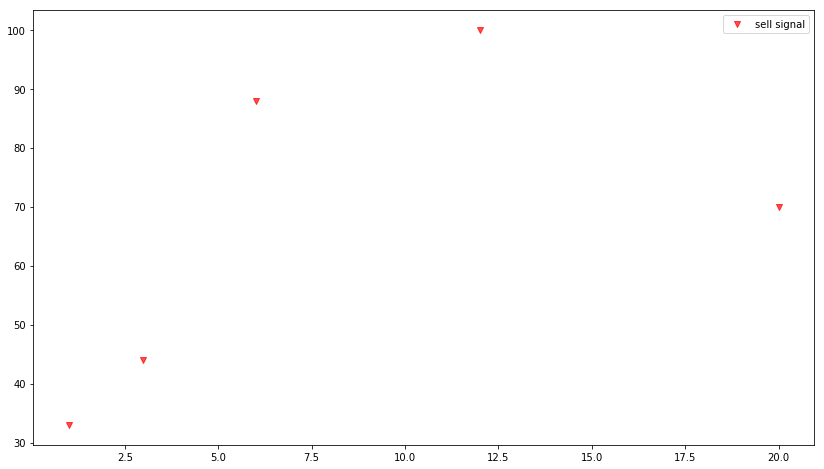

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.gcf()
fig.set_size_inches(14, 8)
# x = np.array([i for i in range(len(sells))])
# s = np.random.rand(*x.shape) * 100
# plt.scatter(x, sells, c="r", s= s, alpha=0.7, label = "sell signal",marker="v")
# plt.scatter(x, buys, c="y", s= s, alpha=0.7, label = "buy signal",marker="^")
# plt.plot(test_price.values, label = "close price", linewidth=3)
# plt.legend()
# plt.show()
x = [1,3,6,12,20]
y = [33,44,88,100,70]

plt.scatter(x, y, c="r", alpha=0.7, label = "sell signal",marker="v")
plt.legend()
plt.show()